<a href="https://colab.research.google.com/github/tommyarmstrong/WhatsAppAnalysis/blob/main/WhatsAppAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [579]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import datetime as dt
from seaborn import *
from seaborn import heatmap as heatmap
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
from nltk import *
from plotly import express as px
!pip install emoji
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [580]:
from importlib import reload
plt=reload(plt)

In [581]:
message1 = "Ruth (Nellie's Mum): Hi all. Just adding Tommy."

message2 = "Ruth (Nellie’s Mum): Hi all. Just adding Tommy."

pattern = "\w+\s+\(\w+\’\w+\s+\w+\):"

print(f'Message1 type: {type(message1)}')
print(f'Message1 length: {len(message1)}')
print(f'Message2 type: {type(message2)}')
print(f'Message2 length: {len(message2)}')



result = re.match(pattern, message1)
if result:
  print(f'Match\n{message1}')
else:
  print('No Match')



Message1 type: <class 'str'>
Message1 length: 47
Message2 type: <class 'str'>
Message2 length: 47
No Match


In [582]:
# Define functions to use in the data gathering and engineering

def starts_with_datetime(s):
  """
  Check that a string starts with a date and time in the standard format
  """
  pattern = '^([[0-9][0-9]+)(/)([0-9][0-9]+)(/)([0-9][0-9][0-9][0-9]), ([0-9][0-9]+):([0-9][0-9]+):([0-9][0-9])'
  result = re.match(pattern, s)
  if result:
    return True
  return False

def contains_name(s):
  """
  Check that a string begins with a person's name or 
  phone number and a semicolon
  """
  patterns = [
        '\w+:',                    # First Name
        '\w+\s+\w+:',              # First Name + Last Name
        '\w+\s+\w+\s+\w+:',        # First Name + Middle Name + Last Name
        '\w+\s+\(\w+\’\w+\s+\w+\):',        # First Name + (Name's Mum)        
        '\w+\s+\w+\s+\(\w+\’\w+\s+\w+\):',        # First Name + (Name's Mum)        
        '[\u202a][+]\d{2}[\xa0]\d{4}[\xa0]\d{6}[\u202c]:'   # Mobile Number (UK) (including unicode)
        # '([w]+)[u263a-U0001f999]+:',  # Name and Emoji              
  ]
  pattern = '^' + '|'.join(patterns)
  result = re.match(pattern, s)
  if result:
    return True
  return False

def seperate_data_in_string(line): 
  """
  Split a line from a WhatsApp export file, pased as a string, into date, time, 
  author and message components. Then return the components.
  """ 
  line = line[1:]                     # Strip leading '[' from the string
  split_line = line.split('] ')       # Split on the first ']' character
  date_time = split_line[0]
  date, time = date_time.split(', ')  # Split date and time on the ',' seperator
  message = ''.join(split_line[1:])
  if contains_name(message):          # Confirm message begins with an author name
    split_message = message.split(':')  # Split the name from the message
    author = split_message[0] 
    message = ' '.join(split_message[1:])
  else: 
    author = None
  return date, time, author, message

def parse_whatsapp_export(fp):
  """ 
  Read a WhatsApp export file passed as an open file handle.
  Parse each line of text in the file.
  Call a funtion to seperate each line on the export into date, time, person 
  and message components and append them to rows of a Pandas dataframe. 
  Return the dataframe.
  """  
  parsed_data = []
  message_buffer = [] 
  date, time, person = None, None, None    
  while True:
    line = fp.readline() 
    if not line: 
      break
    line = line.strip() 
    if starts_with_datetime(line): 
      if len(message_buffer) > 0: 
        parsed_data.append([date, time, person, ''.join(message_buffer)]) 
      message_buffer.clear() 
      date, time, person, message = seperate_data_in_string(line) 
      message_buffer.append(message.strip())
    else:
      message_buffer.append(line)
  df = pd.DataFrame(parsed_data, columns=['date', 'time', 'person', 'message'])
  return df

def load_whatsapp_export(file_name):
  """
  Open the WhatsApp export file from Google Drive and return the file
  """

  from pathlib import Path
  from google.colab import drive

  drive.mount('/content/drive', force_remount=True)
  file_path = '/content/drive/MyDrive/Data Sets'
  file_path = file_path + '/' + chat_file_name

  if Path(file_path).is_file():
    print(f"Data exists in Google Drive.\nImporting from:\n{file_path}.")
    with open(file_path, encoding="utf-8") as fp:
      df = parse_whatsapp_export(fp)
      return df
  else:
    print(f"Data DOES NOT exist in Google Drive.")
    return pd.DataFrame()

def average_sentiment_scores(df):
  x1 = df["nltk_positive"].mean()
  x2 = df["nltk_negative"].mean()
  x3 = df["nltk_neutral"].mean()
  x4 = df["nltk_compound"].mean()
  sentiment_headline(x4)
  print(f'\tcompound: {round(x4*100, 1)}%')
  print(f'\tpositive: {round(x1*100, 1)}%')
  print(f'\tnegative: {round(x2*100, 1)}%')
  print(f'\tneutral:  {round(x3*100, 1)}%')

def sentiment_headline(compound):
    if compound > 0.05:
        print('Sentiment: Positive')
    elif compound > -0.05:
        print('Sentiment: Neutral')
    else:
        print('Sentiment: Negative')


In [583]:
# Configure the filename for the WhatsApp export file
#chat_name = 'Glenwood Road Residents'
#chat_name = 'Antoniooooo'
#chat_name = 'Grecian 3000'
chat_name = 'WGP - Orange Class'

chat_file_name = 'WhatsApp Chat - ' + chat_name + '.txt'

# Create a dataframe from WhatsApp messages for analysis
df = load_whatsapp_export(chat_file_name)

df.head()

Mounted at /content/drive
Data exists in Google Drive.
Importing from:
/content/drive/MyDrive/Data Sets/WhatsApp Chat - WGP - Orange Class.txt.


,date,time,person,message
0,29/06/2020,17:14:19,None,WGP - Orange Class🍊: ‎Messages and calls are e...
1,29/06/2020,17:14:19,None,‎Jess (Teddy’s Mam) created this group
2,11/08/2020,20:09:16,None,‎Ruth (Nellie’s Mum) added you
3,11/08/2020,20:10:21,Ruth (Nellie’s Mum),Hi all. Just adding Tommy who’s little boy Jac...
4,11/08/2020,20:11:52,Ruth (Nellie’s Mum),There’s a plan to meet up on 30th August at 11...


In [584]:
df.shape

(3370, 4)

In [585]:
# Create a datatime column
df["date_time"] = pd.to_datetime(df["date"], dayfirst=True)

In [586]:
# View the contributions by person
df.groupby('person').count()

,date,time,message,date_time
person,,,,
Andrew (Nazaret’s Dad),6,6,6,6
Catherine (Arthur’s Mam),178,178,178,178
Cecilia (Oliver’s Mam),563,563,563,563
Dan (Zuzu’s Dad),47,47,47,47
David Clouston (Erin’s Dad),51,51,51,51
Gabriel Hull (Billy’s Mum),45,45,45,45
George (Alexander’s Dad),38,38,38,38
Gregg Morgan (Nellie’s Dad),40,40,40,40
Henrietta Curtis,44,44,44,44


In [587]:
# Remove the system message
df = df[df.person != chat_name]

In [588]:
# View NANs
df.isnull().sum()

date           0
time           0
person       320
message        0
date_time      0
dtype: int64

In [589]:
# Remove the NaN rows. These are private key change notifications
df = df.dropna()
df.shape

(3050, 5)

In [590]:
# Count number of letters in each message
df['characters'] = df['message'].apply(lambda s : len(s))

# Count number of word's in each message
df['words'] = df['message'].apply(lambda s : len(s.split(' ')))

# Count number of http(s) links
url_pattern = '(https?://\S+)'
df['url_count'] = df.message.apply(lambda s: re.findall(url_pattern, s)).str.len()

# Count number of media messages
image_pattern = 'image omitted'
df['media_count'] = df.message.apply(lambda s: re.findall(image_pattern, s)).str.len()

In [591]:
# Print overall statistics for the group
total_messages = df.shape[0]
media_messages = np.sum(df.media_count)
links = np.sum(df.url_count)
links_perc = links / total_messages * 100
media_perc = media_messages / total_messages * 100

print('Group Stats'.upper())
print(f'Total messages: {total_messages}')
print(f'Total images: {media_messages} ({round(media_perc, 1)}%)')
print(f'Total http(s) links: {links} ({round(links_perc, 1)}%)')

GROUP STATS
Total messages: 3050
Total images: 224 (7.3%)
Total http(s) links: 35 (1.1%)


In [592]:
# Print stats for each author
people = df.person.unique()
for person in people:
  person_df = df[df['person'] == person]
  print(person.upper())
  print(f"Total messages sent: {person_df.shape[0]}")
  
  words_per_message = np.sum(person_df['words']) / person_df.shape[0]
  print(f'Words per message: {round(words_per_message, 1)}')

  media = np.sum(person_df['media_count'])
  print(f'Media messages sent: {media} ({round(media/person_df.shape[0]*100)}%)')

  urls = np.sum(person_df['url_count'])
  print(f'Links sent: {urls} ({round(urls/person_df.shape[0]*100,1)}%)')
  print('------------------------------') 

RUTH (NELLIE’S MUM)
Total messages sent: 65
Words per message: 14.3
Media messages sent: 3 (5%)
Links sent: 1 (1.5%)
------------------------------
TOMMY
Total messages sent: 56
Words per message: 19.0
Media messages sent: 9 (16%)
Links sent: 1 (1.8%)
------------------------------
ROS SARAI (LEILA’S MAM)
Total messages sent: 397
Words per message: 15.1
Media messages sent: 24 (6%)
Links sent: 6 (1.5%)
------------------------------
CATHERINE (ARTHUR’S MAM)
Total messages sent: 178
Words per message: 18.1
Media messages sent: 25 (14%)
Links sent: 0 (0.0%)
------------------------------
CECILIA (OLIVER’S MAM)
Total messages sent: 563
Words per message: 14.1
Media messages sent: 25 (4%)
Links sent: 5 (0.9%)
------------------------------
IZABELLE (ROWAN’S MUM)
Total messages sent: 138
Words per message: 16.3
Media messages sent: 2 (1%)
Links sent: 0 (0.0%)
------------------------------
JESS (TEDDY’S MAM)
Total messages sent: 24
Words per message: 21.0
Media messages sent: 0 (0%)
Links s

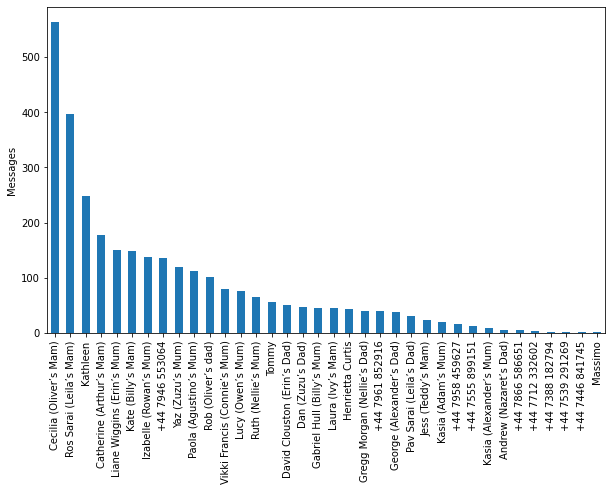

In [593]:
# Plot people with most messages
plt.figure(figsize=(10,6))
df['person'].value_counts().plot.bar()
plt.ylabel('Messages')
plt.show()

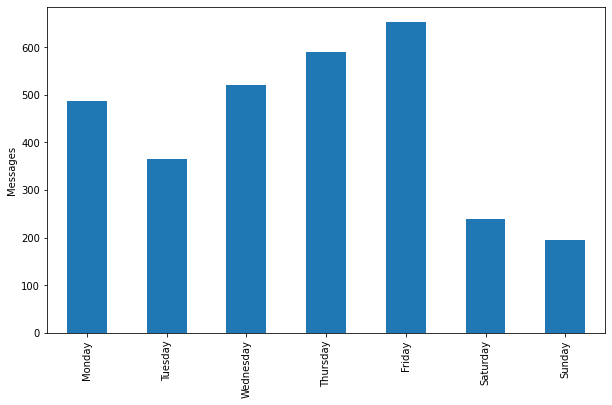

In [594]:
# Plot meesages on each day

# Days column in readable form
days_dict = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thursday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}
df['day'] = df['date_time'].dt.weekday.map(days_dict)

# Arrange days order
days = df['day'].value_counts()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = days.reindex(days_order)

# Plot days
plt.figure(figsize=(10,6))
plt.ylabel('Messages')
days.plot.bar()
plt.show()

In [595]:
# Plot messages by datetime
date_df = df.groupby('date_time').count().reset_index(drop=False)
px.line(date_df, x=date_df['date_time'], y=date_df['message'])

In [596]:
# There are six months of missing data between 24/1/2018 and 19/7/2018

missing_data = df[(df['date_time'].dt.year == 2018) & (df['date_time'].dt.month < 8)]
missing_data.groupby('date', sort=False).count()

,time,person,message,date_time,characters,words,url_count,media_count,day
date,,,,,,,,,


In [597]:
# Label with readable month and year 
df['year'] = df['date_time'].dt.strftime('%Y')
df['month_number'] = df['date_time'].dt.month
months = {
     1 : 'Jan',
     2 : 'Feb',
     3 : 'Mar',
     4 : 'Apr',
     5 : 'May',
     6 : 'Jun',
     7 : 'Jul',
     8 : 'Aug',
     9 : 'Sep',
    10 : 'Oct',
    11 : 'Nov',
    12 : 'Dec'
}
df['month'] = df['month_number'].map(months)
df.drop('month_number',axis=1,inplace=True)
df['month_year'] = df['month'] + ' ' + df['year']

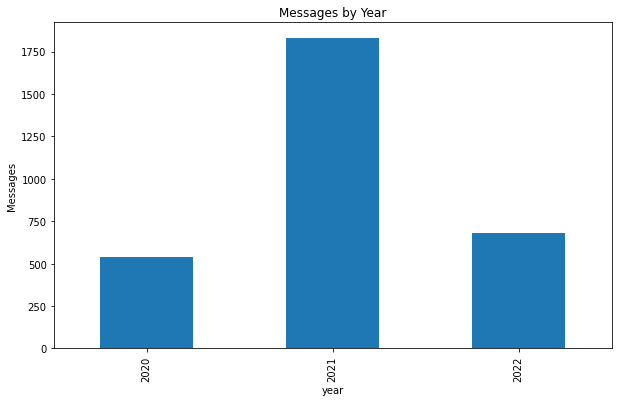

In [598]:
# Plot messages per year
year_df = df.groupby('year').count()['message']

plt.figure(figsize=(10,6))
plt.ylabel('Messages')
plt.title('Messages by Year')
year_df.plot.bar()
plt.show()


In [599]:
# Plot messsages by month
month_df = df.groupby('month_year', sort=False).count().reset_index(drop=False)
px.line(month_df, x=month_df['month_year'], y=month_df['message'])

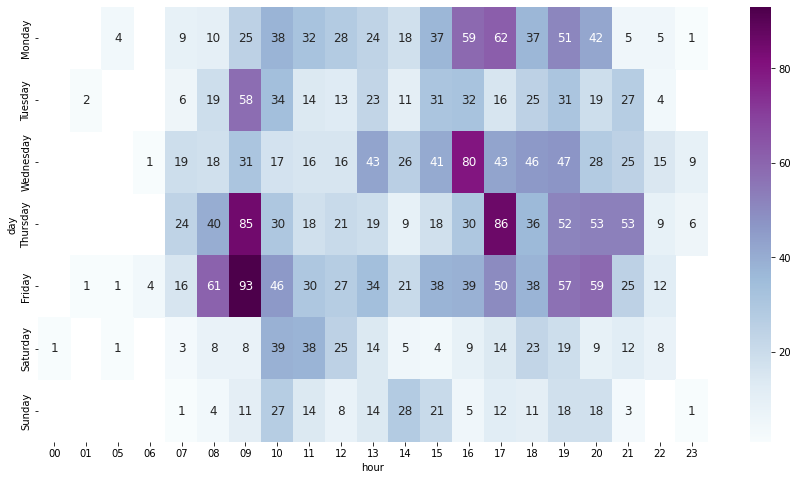

In [600]:
# Plot heatmap of days vs hour with value of total messages

# Hours column 
df['hour'] = df['time'].apply(lambda x : x.split(':')[0])

# Rectangular array needed for heatmap
heat_df = df.pivot_table(index='day', columns='hour', values='message', aggfunc='count')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heat_df = heat_df.reindex(days_order)

# Plot heatmap
plt.figure(figsize=(15,8))
heatmap(
    data=heat_df,
    cmap="BuPu",
    annot=True, fmt=".0f", annot_kws={"size":12}
    )
plt.show()

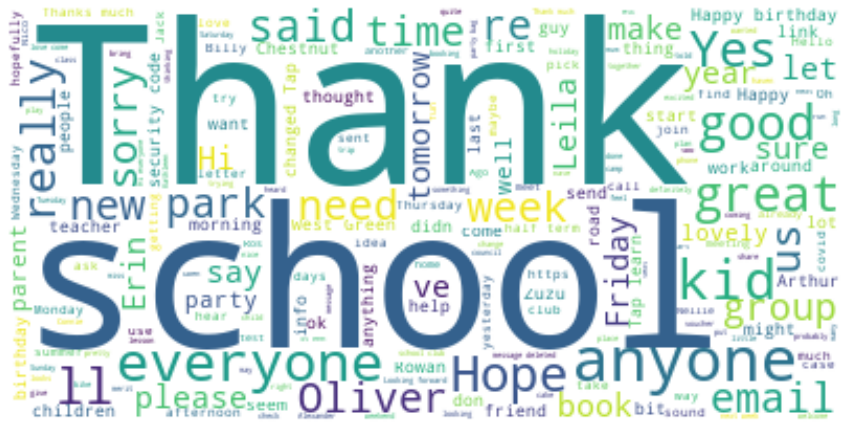

In [601]:
# Create a Word Cloud

# Exclude common words that provide no insight
# STOPWORDS are provided by the WordCloud library
# Add additional STOPWORDS relevant to these data
word_cloud_df = df[df['media_count'] == 0]
exclude_words = {'one', 'got', 'will', 'go', 'going', 'think', 'day', 'now', 'know', 'see', 'back', 'today', 'still', 'look', 'Smith', 'Jez', 'Trav'}
STOPWORDS.update(exclude_words)

# Join all messages into a single string called 'text' and generate WordCloud
text = ''.join(msg for msg in word_cloud_df.message)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(text)

# Plot
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# The word cloud seems to show very common words are the most predominent 

In [602]:
# Create a sentiment analysis on each message using the NLTK VADER analyser

try:
  sid = SentimentIntensityAnalyzer()
except LookupError:
  import nltk
  nltk.download('vader_lexicon')
  sid = SentimentIntensityAnalyzer()

df['nltk_compound'] = df['message'].apply(lambda x:sid.polarity_scores(x)['compound'])
df['nltk_positive'] = df['message'].apply(lambda x:sid.polarity_scores(x)['pos'])
df['nltk_negative'] = df['message'].apply(lambda x:sid.polarity_scores(x)['neg'])
df['nltk_neutral'] = df['message'].apply(lambda x:sid.polarity_scores(x)['neu'])


In [603]:
# Compare the sentiment scores across people
df.groupby('person').mean()

,characters,words,url_count,media_count,nltk_compound,nltk_positive,nltk_negative,nltk_neutral
person,,,,,,,,
Andrew (Nazaret’s Dad),23.500000,5.000000,0.000000,0.000000,0.168717,0.171667,0.000000,0.828333
Catherine (Arthur’s Mam),102.112360,18.089888,0.000000,0.140449,0.500572,0.322320,0.041702,0.635972
Cecilia (Oliver’s Mam),79.431616,14.138544,0.008881,0.044405,0.188214,0.156245,0.048460,0.789970
Dan (Zuzu’s Dad),122.191489,21.319149,0.021277,0.042553,0.428462,0.249128,0.032255,0.697319
David Clouston (Erin’s Dad),86.490196,14.019608,0.078431,0.078431,0.111739,0.132529,0.045725,0.821765
Gabriel Hull (Billy’s Mum),70.133333,13.200000,0.000000,0.000000,0.304033,0.277733,0.047578,0.652489
George (Alexander’s Dad),72.815789,14.052632,0.000000,0.052632,0.121366,0.169105,0.033474,0.692158
Gregg Morgan (Nellie’s Dad),78.925000,15.100000,0.000000,0.075000,0.367415,0.296750,0.033300,0.644950
Henrietta Curtis,87.136364,15.954545,0.000000,0.113636,0.585761,0.437000,0.027727,0.535273


In [604]:
people = df.person.unique()
for person in people:
  print(person.upper())
  average_sentiment_scores(df[df['person'] == person])
  print('-------------')

RUTH (NELLIE’S MUM)
Sentiment: Positive
	compound: 49.5%
	positive: 31.5%
	negative: 1.6%
	neutral:  66.9%
-------------
TOMMY
Sentiment: Positive
	compound: 29.4%
	positive: 19.7%
	negative: 1.5%
	neutral:  78.8%
-------------
ROS SARAI (LEILA’S MAM)
Sentiment: Positive
	compound: 20.6%
	positive: 16.9%
	negative: 4.8%
	neutral:  77.4%
-------------
CATHERINE (ARTHUR’S MAM)
Sentiment: Positive
	compound: 50.1%
	positive: 32.2%
	negative: 4.2%
	neutral:  63.6%
-------------
CECILIA (OLIVER’S MAM)
Sentiment: Positive
	compound: 18.8%
	positive: 15.6%
	negative: 4.8%
	neutral:  79.0%
-------------
IZABELLE (ROWAN’S MUM)
Sentiment: Positive
	compound: 23.6%
	positive: 20.9%
	negative: 7.3%
	neutral:  71.0%
-------------
JESS (TEDDY’S MAM)
Sentiment: Positive
	compound: 38.4%
	positive: 23.8%
	negative: 3.1%
	neutral:  68.9%
-------------
PAOLA (AGUSTINO’S MUM)
Sentiment: Positive
	compound: 37.7%
	positive: 26.7%
	negative: 2.4%
	neutral:  68.2%
-------------
LIANE WIGGINS (ERIN’S MUM)
Se

In [605]:
# Plot sentiment across all years 
temp_df = df.groupby('year', sort=False).mean().reset_index(drop=False)
px.bar(temp_df, x=temp_df['year'], y=temp_df['nltk_compound'])

In [606]:
# Plot how people's sentiment changes over time 
temp_df = df.pivot_table('nltk_compound', 'year', 'person', aggfunc='mean').reset_index(drop=False)
people = df.person.unique()
temp_df = pd.melt(temp_df, id_vars=['year'], value_vars=people)
temp_df.columns = ['year', 'person', 'sentiment']
px.line(temp_df, x='year', y='sentiment', color='person')

In [607]:
px.box(df, x='person', y='nltk_compound')

# Unclear why all box plots have a medium = 0. Seems wrong. 

In [608]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050 entries, 3 to 3369
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3050 non-null   object        
 1   time           3050 non-null   object        
 2   person         3050 non-null   object        
 3   message        3050 non-null   object        
 4   date_time      3050 non-null   datetime64[ns]
 5   characters     3050 non-null   int64         
 6   words          3050 non-null   int64         
 7   url_count      3050 non-null   int64         
 8   media_count    3050 non-null   int64         
 9   day            3050 non-null   object        
 10  year           3050 non-null   object        
 11  month          3050 non-null   object        
 12  month_year     3050 non-null   object        
 13  hour           3050 non-null   object        
 14  nltk_compound  3050 non-null   float64       
 15  nltk_positive  3050 n